# АНАЛИЗ статистической значимости метрик


# Переменная непрерывна

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Случайные данные AUC двух моделей
np.random.seed(0)
auc_model_a = np.random.normal(loc=0.83, scale=0.01, size=100)
auc_model_b = np.random.normal(loc=0.845, scale=0.01, size=100)

# 1. Средние значения
mean_a = np.mean(auc_model_a)
mean_b = np.mean(auc_model_b)
print(f'среднее по А: {mean_a}')
print(f'среднее по Б: {mean_b}')

# 2. Разность средних
mean_diff = mean_b - mean_a
print(f'дельта средних: {mean_diff}')

среднее по А: 0.8305980801553448
среднее по Б: 0.8458201297074784


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

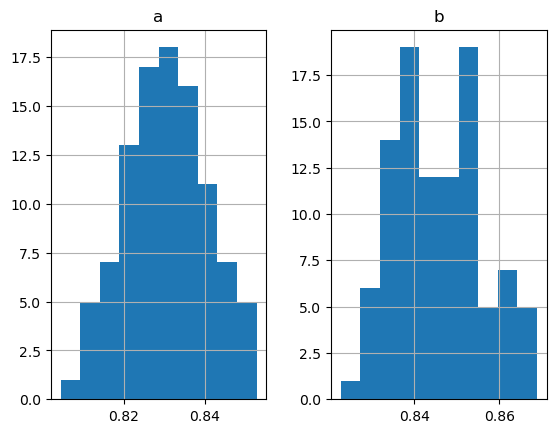

In [80]:
pd.DataFrame({'a':auc_model_a,'b':auc_model_b}).hist()

## t-test

In [162]:
# Разности между значениями
diffs = auc_model_b - auc_model_a
n = len(diffs)
mean_diff = np.mean(diffs)
std_diff = np.std(diffs, ddof=1) 

# Стандартная ошибка
se_diff = std_diff / np.sqrt(n)

# t-статистика
t_stat = mean_diff / se_diff

# p-value (через нормальное приближение)
def normal_cdf(x):
    return (1 + erf(x / sqrt(2))) / 2

p_value = 2 * (1 - normal_cdf(abs(t_stat)))

# 95% доверительный интервал
z_critical = 1.96
ci_low = mean_diff - z_critical * se_diff
ci_high = mean_diff + z_critical * se_diff

{
    "Mean difference": round(mean_diff, 4),
    "Standard error": round(se_diff, 6),
    "t-statistic": round(t_stat, 4),
    "p-value": round(p_value, 6),
    "95% CI": [round(ci_low, 4), round(ci_high, 4)]
}

{'Mean difference': 0.0152,
 'Standard error': 0.001368,
 't-statistic': 11.1254,
 'p-value': 0.0,
 '95% CI': [0.0125, 0.0179]}

## Wilcoxon (ранговый тест)

In [163]:
# Повторное выполнение после сброса окружения
import numpy as np
from scipy.stats import wilcoxon

# Воссоздаем данные
np.random.seed(0)
auc_model_a = np.random.normal(loc=0.83, scale=0.01, size=100)
auc_model_b = np.random.normal(loc=0.845, scale=0.01, size=100)

# Разности
diffs = auc_model_b - auc_model_a

# Wilcoxon signed-rank test
w_stat, p_value_wilcoxon = wilcoxon(diffs)

round(w_stat, 4), round(p_value_wilcoxon, 6)

(298.0, 0.0)

## Permutation test 

In [165]:
import numpy as np

# Повторим генерацию данных
np.random.seed(0)
auc_model_a = np.random.normal(loc=0.83, scale=0.01, size=100)
auc_model_b = np.random.normal(loc=0.845, scale=0.01, size=100)

# Вычисляем наблюдаемую разность средних
observed_diff = np.mean(auc_model_b) - np.mean(auc_model_a)

In [166]:
# Объединяем все значения
combined = np.concatenate([auc_model_a, auc_model_b])

In [168]:
# Перестановочный тест (пермутации)
n_permutations = 10000
permuted_diffs = []

for _ in range(n_permutations):
    np.random.shuffle(combined)
    perm_a = combined[:100]
    perm_b = combined[100:]
    permuted_diffs.append(np.mean(perm_b) - np.mean(perm_a))

permuted_diffs = np.array(permuted_diffs)

# Эмпирическое p-value (двусторонний тест)
empirical_p = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))

round(observed_diff, 4), round(empirical_p, 6)

(0.0152, 0.0)

## Бутстрап доверительный интервал

In [176]:
np.random.seed(0)
n_bootstrap = 10000
bootstrap_diffs = []

# Бутстрап: семплируем с возвращением внутри каждой группы
for _ in range(n_bootstrap):
    sample_a = np.random.choice(auc_model_a, size=len(auc_model_a), replace=True)
    sample_b = np.random.choice(auc_model_b, size=len(auc_model_b), replace=True)
    bootstrap_diffs.append(np.mean(sample_b) - np.mean(sample_a))

bootstrap_diffs = np.array(bootstrap_diffs)

# 95% доверительный интервал
ci_bootstrap = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Средняя оценка эффекта
bootstrap_mean = np.mean(bootstrap_diffs)

bootstrap_mean, ci_bootstrap.round(4)

(0.015230753585120044, array([0.0124, 0.018 ]))

## Баейсовский подход
Вместо вопроса - "Верна ли нулевая гипотеза?" Задается вопрос - "С какой вероятностью одна модель лучше другой?"

In [ ]:
import numpy as np

np.random.seed(0)
auc_model_a = np.random.normal(loc=0.83, scale=0.01, size=100)
auc_model_b = np.random.normal(loc=0.845, scale=0.01, size=100)

# Байесовский подход — аппроксимация нормальными постериорами
n_samples = 100000

# Параметры аппроксимации
mean_a, std_a = np.mean(auc_model_a), np.std(auc_model_a, ddof=1) / np.sqrt(len(auc_model_a))
mean_b, std_b = np.mean(auc_model_b), np.std(auc_model_b, ddof=1) / np.sqrt(len(auc_model_b))

# Сэмплируем постериоры
posterior_a = np.random.normal(loc=mean_a, scale=std_a, size=n_samples)
posterior_b = np.random.normal(loc=mean_b, scale=std_b, size=n_samples)

# Разности
delta = posterior_b - posterior_a

# Вероятность того, что модель B лучше A
prob_b_better = np.mean(delta > 0)

# Байесовский 95% интервал
bayes_ci = np.percentile(delta, [2.5, 97.5])

round(prob_b_better, 4), bayes_ci.round(4)

## Регрессии

In [202]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

df_a = pd.DataFrame({
    'metric': auc_model_a})
df_a['model'] = 'A'

df_b = pd.DataFrame({
    'metric': auc_model_b})
df_b['model'] = 'B'
df = pd.concat([df_a,df_b],axis =0)

le = LabelEncoder()
df['model'] = le.fit_transform(df['model'])

X = sm.add_constant(df[['model']])
y = df['metric']

result = sm.OLS(y, X).fit()

# выводим summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 metric   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     109.9
Date:                Fri, 09 May 2025   Prob (F-statistic):           9.62e-21
Time:                        16:37:14   Log-Likelihood:                 633.02
No. Observations:                 200   AIC:                            -1262.
Df Residuals:                     198   BIC:                            -1255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8306      0.001    809.149      0.0

# Переменная дискретна

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

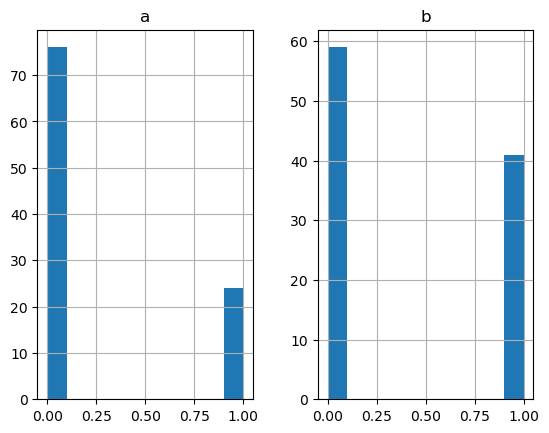

In [207]:
import numpy as np
from math import erf, sqrt

np.random.seed(42)

# Группа A: 100 наблюдений, 25% успехов
group_a = np.random.binomial(1, 0.25, size=100)

# Группа B: 100 наблюдений, 40% успехов
group_b = np.random.binomial(1, 0.40, size=100)

# Пропорции успехов
p1 = np.mean(group_a)
p2 = np.mean(group_b)
pd.DataFrame({'a':group_a,'b':group_b}).hist()

## Z-test

In [211]:
# Пропорции успехов и размеры
p1 = np.mean(group_a)
p2 = np.mean(group_b)
n1 = len(group_a)
n2 = len(group_b)

# Непул стандартная ошибка
se_unpooled = np.sqrt((p1 * (1 - p1)) / n1 + (p2 * (1 - p2)) / n2)

# Z-статистика и p-value
z_unpooled = (p2 - p1) / se_unpooled
p_value_unpooled = 2 * (1 - normal_cdf(abs(z_unpooled)))

# 95% доверительный интервал
z_crit = 1.96
ci_low = (p2 - p1) - z_crit * se_unpooled
ci_high = (p2 - p1) + z_crit * se_unpooled

round(p1, 3), round(p2, 3), round(z_unpooled, 4), round(p_value_unpooled, 6), (round(ci_low, 4), round(ci_high, 4))

(0.24, 0.41, 2.6098, 0.009059, (0.0423, 0.2977))

## Фишер (для малых выборок)

In [212]:
from scipy.stats import fisher_exact

# Построим таблицу сопряжённости:
#         success | fail
#  group A   a    | b
#  group B   c    | d

a = np.sum(group_a == 1)
b = np.sum(group_a == 0)
c = np.sum(group_b == 1)
d = np.sum(group_b == 0)

# Таблица 2x2
table = [[a, b], [c, d]]

# Точный тест Фишера (двусторонний)
oddsratio, p_value_fisher = fisher_exact(table, alternative='two-sided')

table, round(oddsratio, 4), round(p_value_fisher, 6)

([[24, 76], [41, 59]], 0.4544, 0.015384)

## Хи-квадрат

In [213]:
from scipy.stats import chi2_contingency

# Используем ту же таблицу сопряжённости
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(table)

round(chi2_stat, 4), round(p_value_chi2, 6), dof, expected.round(2).tolist()

(5.8348, 0.015713, 1, [[32.5, 67.5], [32.5, 67.5]])

## Перестановочный тест

In [214]:
# Перестановочный тест для бинарных переменных

# Объединяем все данные
combined_binary = np.concatenate([group_a, group_b])
labels = np.array([0]*len(group_a) + [1]*len(group_b))  # 0=A, 1=B

# Наблюдаемая разность пропорций
obs_diff = np.mean(group_b) - np.mean(group_a)

# Перестановки
n_permutations = 10000
perm_diffs = []

for _ in range(n_permutations):
    shuffled_labels = np.random.permutation(labels)
    group_a_perm = combined_binary[shuffled_labels == 0]
    group_b_perm = combined_binary[shuffled_labels == 1]
    diff = np.mean(group_b_perm) - np.mean(group_a_perm)
    perm_diffs.append(diff)

# Эмпирическое p-value
perm_diffs = np.array(perm_diffs)
p_value_perm = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))

round(obs_diff, 4), round(p_value_perm, 6)

(0.17, 0.0158)

## бутстрап CI

In [215]:
# Бутстрап-доверительный интервал разности долей

n_bootstrap = 10000
bootstrap_diffs = []

for _ in range(n_bootstrap):
    sample_a = np.random.choice(group_a, size=len(group_a), replace=True)
    sample_b = np.random.choice(group_b, size=len(group_b), replace=True)
    diff = np.mean(sample_b) - np.mean(sample_a)
    bootstrap_diffs.append(diff)

bootstrap_diffs = np.array(bootstrap_diffs)
ci_bootstrap = np.percentile(bootstrap_diffs, [2.5, 97.5])
mean_bootstrap_diff = np.mean(bootstrap_diffs)

round(mean_bootstrap_diff, 4), ci_bootstrap.round(4).tolist()

(0.1702, [0.04, 0.3])

## Логистическая регрессия

In [222]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

np.random.seed(42)

# Группа A: 100 наблюдений, 25% успехов
group_a = np.random.binomial(1, 0.25, size=100)

# Группа B: 100 наблюдений, 40% успехов
group_b = np.random.binomial(1, 0.40, size=100)


df_a = pd.DataFrame({
    'metric': group_a})
df_a['model'] = 'A'

df_b = pd.DataFrame({
    'metric': group_b})
df_b['model'] = 'B'
df = pd.concat([df_a,df_b],axis =0)

le = LabelEncoder()
df['model'] = le.fit_transform(df['model'])

X = sm.add_constant(df[['model']])
y = df['metric']

model = sm.Logit(y, X)
result = model.fit()

# выводим summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.613969
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 metric   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 May 2025   Pseudo R-squ.:                 0.02634
Time:                        18:49:45   Log-Likelihood:                -122.79
converged:                       True   LL-Null:                       -126.12
Covariance Type:            nonrobust   LLR p-value:                  0.009945
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1527      0.234     -4.923      0.000      -1.612      -0.694
model          0.7887      0.

## Это что-то допом

In [ ]:
 3. 95% доверительные интервалы через бутсрап
# На этом шаге мы централизуем бутстрап, как будт-то эффект  = 0

diffs = auc_model_b - auc_model_a
# Центрируем разности относительно 0, чтобы бутстрап был под H0: delta = 0
centered_diffs = diffs - mean_diff  # это как "обнуление эффекта"

# Бутстрап распределение под H0: delta = 0
null_bootstrap_means = []
for _ in range(10000):
    sample_idx = np.random.choice(len(centered_diffs), size=len(centered_diffs), replace=True)
    sample_mean = np.mean(centered_diffs[sample_idx])
    null_bootstrap_means.append(sample_mean)

null_bootstrap_means = np.array(null_bootstrap_means)

# Доверительный интервал по null-распределению
ci_null = np.percentile(null_bootstrap_means, [2.5, 97.5])

# p-value: доля, где null-распределение даёт среднюю разность ≥ наблюдаемой
empirical_p_null = np.mean(np.abs(null_bootstrap_means) >= np.abs(mean_diff))

print(f'доверительный интервал: {ci_null.round(4)}')
print(f'p-value: {round(empirical_p_null, 4)}')
Доверительный интервал НЕ включает наблюдаемую разность, значит мы можем утверждать с 95% уверенностью что эффект НЕ СЛУЧАЙНЫЙ.

P- value  низкий отвергаем нулевую гипотезу о равенстве. Эффект есть